In [52]:
# Standard library imports
import os
import sys

from typing import Dict
import rioxarray

# Third-party library imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rioxarray.exceptions import NoDataInBounds 
from shapely.geometry import Point, box
import xarray as xr

from utils.preprocessing import prepare_kdtree, interpolate_variable, interpolate_and_merge_optimized, get_altitude
from utils.plots import plot_hydrographic_maps
from utils.data_loader import load_hydro_data, read_soil_data, read_altitude_data, load_water_flows, load_station_info, load_meteo_data

In [53]:
# Declare constants

AREAS = ["brazil", "france"]
DATASET_DIR = "dataset/"
EVAL_DIR, INPUT_DIR = "data/evaluation/", "data/input/"

# Declare variables

datasets = { "train": INPUT_DIR, "eval" : EVAL_DIR}

# GDF stands for geo data frame
gdf_region, gdf_sector, gdf_sub_sector, gdf_zone = {}, {}, {}, {}
soil_ds = {}
precipitations, temperatures, soil_moisture, evaporation = {}, {}, {}, {}
stations, water_flows = {}, {}

# map GDF key to corresponding dataframe
GDF_KEYS = {
    'region': gdf_region,
    'sector': gdf_sector,
    'sub_sector': gdf_sub_sector,
    'zone': gdf_zone
}

# Info about data structure
JOIN_INFO = {
    'brazil' : {
        "region":    ("wts_pk", "_stations_region",     "_region"),
        "sector":    ("wts_pk", "_stations_sector",     "_sector"),
        "sub_sector":("wts_pk", "_stations_sub_sector", "_sub_sector"),
        "zone":      ("wts_pk", "_stations_zone",       "_zone")
    },
    'france' : {
        "region":    ("CdRegionHydro",      "_stations", "_region"),
        "sector":    ("CdSecteurHydro",     "_stations", "_sector"),
        "sub_sector":("CdSousSecteurHydro", "_stations", "_sub_sector"),
        "zone":      ("CdZoneHydro",        "_stations", "_zone")
    }
}

In [54]:
# Load data

for area in AREAS:
    print(f"Loading {area} static data")
    # Load hydrographic data data from static_data/hydro_areas/
    print("    Loading hydro data")
    hydro_data = load_hydro_data(area, DATASET_DIR)
    for key,gdf in GDF_KEYS.items():
        gdf[area] = hydro_data[key] 

    # Load soil composition data from static_data/soil
    print("    Loading soil data")
    soil_ds[area] = read_soil_data(area, DATASET_DIR)
    
    # Load altitude data from static_data/altitude_DEM 
    # Used to update nonstatic data
    # DEM stands for digital elevation model
    print("    Loading altitude data")
    dem = read_altitude_data(area, DATASET_DIR)

    # Load nonstatic data, i.e. data from {area}/eval/ and {area}/train/
    for type, dataset in datasets.items():
        key = f"{area}_{type}"
        print(f"Loading {key}")

        # Load meteorology data from {area}/{type}/meteo
        meteo_data = load_meteo_data(area, type, DATASET_DIR)
        precipitations[key] = meteo_data['precipitations']
        temperatures[key] = meteo_data['temperatures']
        soil_moisture[key] = meteo_data['soil_moisture']
        evaporation[key] = meteo_data['evaporation']

        # Load station data from {area}/{type}/{waterflow}
        stations[key] = load_station_info(area, type, DATASET_DIR)
        # Update altitude according to DEM
        stations[key]['altitude'] = stations[key].apply(lambda x: get_altitude(x['latitude'], x['longitude'], dem), axis=1)

        # Load waterflow data from {area}/{type}/waterflow
        water_flows[key] = load_water_flows(area, type, DATASET_DIR)

Loading brazil static data
    Loading hydro data
    Loading soil data
    Loading altitude data
Loading brazil_train
Loading brazil_eval
Loading france static data
    Loading hydro data
    Loading soil data
    Loading altitude data
Loading france_train
Loading france_eval


In [55]:
# Add rows to eval_data to predict water flows
for area in AREAS:
    print(f"Updating {area}_eval")
    key = f"{area}_eval"
    new_dfs = []
    block_size = 4

    for i in range(0, len(water_flows[key]), block_size):
        block = water_flows[key].iloc[i : i+block_size].copy()
        new_dfs.append(block)

        # The dataset 
        if len(block) == block_size:
            last_row = block.iloc[-1].copy()
            last_row['ObsDate'] = last_row['ObsDate'] + pd.Timedelta(days=7)
            last_row['discharge'] = float('nan')
            new_dfs.append(pd.DataFrame([last_row]))
    
    water_flows[key] = pd.concat(new_dfs, ignore_index=True)

Updating brazil_eval


Updating france_eval


In [56]:
# Hydrographic area assoication
for area in AREAS:
    for type,dataset in datasets.items():
        key = f"{area}_{type}"
        print(f"Creating area associations for {key}")
        stations[key]['geometry'] = stations[key].apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
        gdf_stations = gpd.GeoDataFrame(stations[key], geometry='geometry', crs="EPSG:4326")

        for gdf in GDF_KEYS.values():
            gdf[area] = gdf[area].to_crs(gdf_stations.crs)

        for level, (col, lsuffix, rsuffix) in JOIN_INFO[area].items():
            gdf_stations = gpd.sjoin(
                gdf_stations,
                GDF_KEYS[level][area][['geometry', col]],
                how="left",
                predicate="within",
                lsuffix=lsuffix,
                rsuffix=rsuffix
            )
        
        # This is an inelegant solution -- allow me to explain.
        # In the first iteration of the above loop, we add a column called wts_pk to gdf_stations.
        # This column stores region-level data. In the second iteration of the loop, gdf_stations
        # has a column called wts_pk, and we are attempting to add  another column called wts_pk.
        # The former wts_pk has region-level data, and  the latter has sector-level data. Ideally,
        # we would rename the columns to wts_pk__region and wts_pk__sector respectively. However,
        # the left suffix in the second iteration of the loop is set to _stations_sector.

        if 'wts_pk__stations_sector' in gdf_stations.columns:
            gdf_stations = gdf_stations.rename(columns={'wts_pk__stations_sector': 'wts_pk__region'})
        if 'wts_pk__stations_zone' in gdf_stations.columns:
            gdf_stations = gdf_stations.rename(columns={'wts_pk__stations_zone': 'wts_pk__sub_sector'})
        
        print(gdf_stations.columns.to_list())

        stations[key] = gdf_stations.drop(columns=['geometry'])
        print(stations[key].columns.to_list(), '\n')

Creating area associations for brazil_train
['station_code', 'station_name', 'river', 'latitude', 'longitude', 'altitude', 'catchment', 'geometry', 'index__region', 'wts_pk__region', 'index__sector', 'wts_pk__sector', 'index__sub_sector', 'wts_pk__sub_sector', 'index__zone', 'wts_pk__zone']
['station_code', 'station_name', 'river', 'latitude', 'longitude', 'altitude', 'catchment', 'index__region', 'wts_pk__region', 'index__sector', 'wts_pk__sector', 'index__sub_sector', 'wts_pk__sub_sector', 'index__zone', 'wts_pk__zone'] 

Creating area associations for brazil_eval
['station_code', 'station_name', 'river', 'latitude', 'longitude', 'altitude', 'catchment', 'geometry', 'index__region', 'wts_pk__region', 'index__sector', 'wts_pk__sector', 'index__sub_sector', 'wts_pk__sub_sector', 'index__zone', 'wts_pk__zone']
['station_code', 'station_name', 'river', 'latitude', 'longitude', 'altitude', 'catchment', 'index__region', 'wts_pk__region', 'index__sector', 'wts_pk__sector', 'index__sub_secto

In [ ]:
# Remove entries with no corresponding station

for area in AREAS:
    key = f"{area}_eval"
    print(f"Filtering {key}")
    for gdf_key,gdf in GDF_KEYS.items():
        gdf[area] = gdf[area][gdf[area].index.isin(stations[key][f"index__{gdf_key}"].unique())]
        gdf[area].name = f"index__{gdf_key}"

Filtering brazil_eval
Filtering france_eval


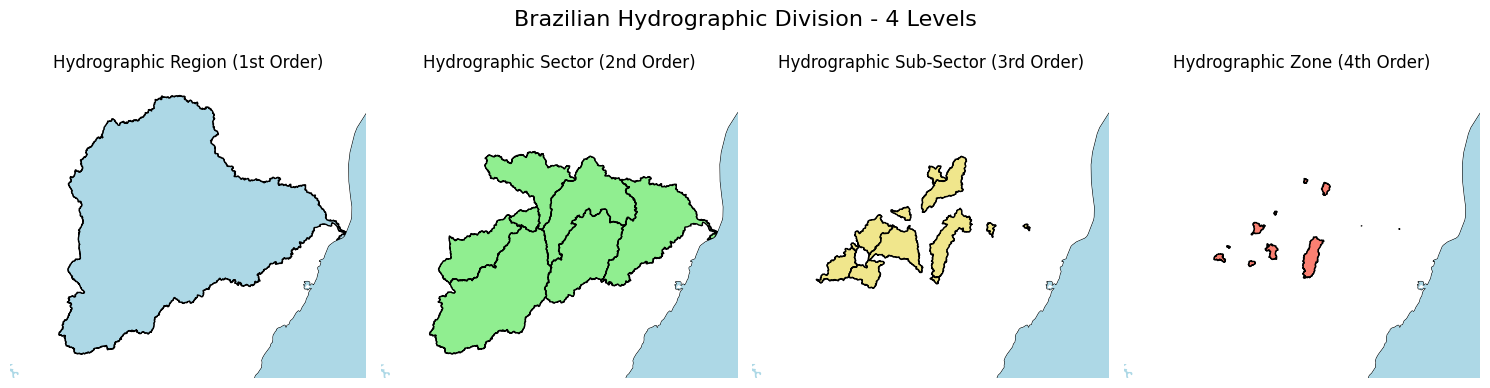

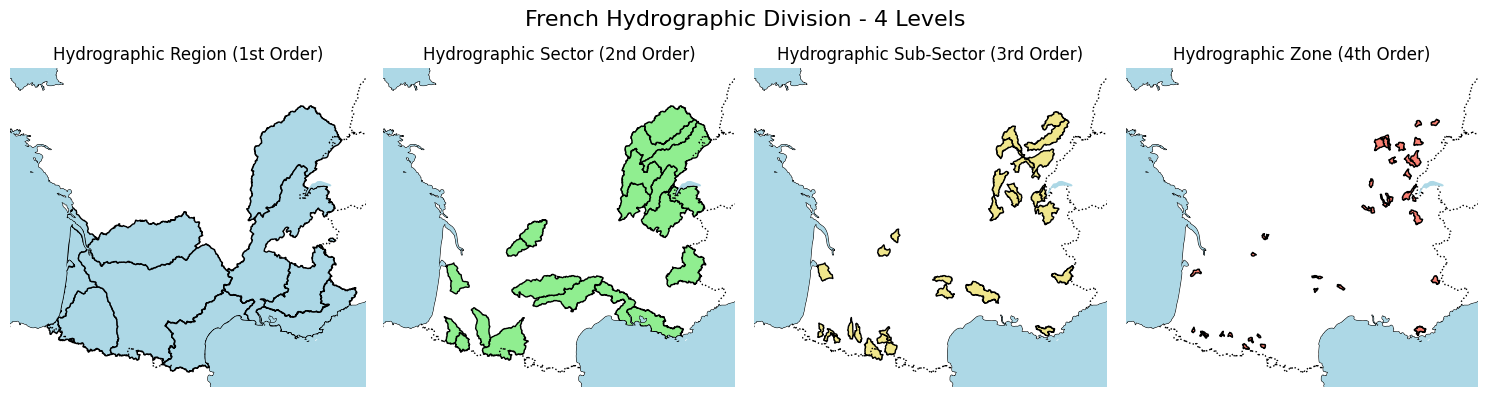

In [59]:
# Plot hydrographic data

BBOX = {
    "brazil": [-44.5, -21.5, -39.5, -17.5],
    "france": [-3, 42.0, 8, 49.0]
}

for area in AREAS:
    plot_hydrographic_maps(area, GDF_KEYS, BBOX)